In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [351]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business', 'general'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [717]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='Digital Transformation at Khalifa Port: Data-Driven Insights')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 5115792#2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

3370982
Title: JR Kyudai Line fully opened, damaged by heavy rain, railway bridges in other sections reused (Asahi Shimbun Digital) - Yahoo! News - Yahoo! News
Description: The JR Kyudai Line, which had been suspended due to heavy rain damage in July last year, resumed operations from the first train on the 1st between Bungomori (Kusu Town, Oita Prefecture) and Yufuin (Yufu City, Oita Prefecture), and the entire line is now open to traffic. Restoration efforts on the Hitahikoyama Line, which was damaged by heavy rains in 2017, have been abandoned.
Original Language: Japanese


In [718]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: JR Kyudai Line fully opened, damaged by heavy rain, railway bridges in other sections reused (Asahi Shimbun Digital) - Yahoo! News - Yahoo! News
Description: The JR Kyudai Line, which had been suspended due to heavy rain damage in July last year, resumed operations from the first train on the 1st between Bungomori (Kusu Town, Oita Prefecture) and Yufuin (Yufu City, Oita Prefecture), and the entire line is now open to traffic. Restoration efforts on the Hitahikoyama Line, which was damaged by heavy rains in 2017, have been abandoned.
Original Language: Japanese
```

Write a 2-3 sentence introduction to a statis

In [719]:
##############################################
motivation_raw = '''
{
  "introduction": "The recent reopening of the JR Kyudai Line, previously halted by heavy rain damage, presents an interesting opportunity to explore the relationship between extreme weather events and public transportation systems. By examining data on the frequency and severity of such weather events, along with the operational records of the railway, we could gain insights into how weather impacts rail travel, specifically looking at delays, cancellations, and restoration efforts.",
  "title": "Impact_of_Extreme_Weather_on_JR_Kyudai_Line_Operations"
}

'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [720]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [731]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
  {
    "name": "Rail Service Disruption",
    "description": "Whether the rail service is significantly disrupted or not",
    "type": "outcome",
    "observed": true,
    "values": ["No Disruption", "Significant Disruption"],
    "parents": ["Emergency Response Preparedness", "Heavy Rain", "Maintenance Efficiency"]
  },
  {
    "name": "Heavy Rain",
    "description": "Incidence of heavy rain in the region",
    "type": "treatment",
    "observed": true,
    "values": ["No Heavy Rain", "Heavy Rain"],
    "parents": ["Regional Climate"]
  },
  {
    "name": "Infrastructure Investment",
    "description": "Level of investment in rail infrastructure",
    "type": "treatment",
    "observed": true,
    "values": ["Low Investment", "High Investment"],
    "parents": ["Government Policy"]
  },
  {
    "name": "Regional Climate",
    "description": "Climatic conditions of the region",
    "type": "confounder",
    "observed": true,
    "values": ["Dry Climate", "Wet Climate"],
    "parents": []
  },
  {
    "name": "Government Policy",
    "description": "Government policies affecting public transportation",
    "type": "confounder",
    "observed": true,
    "values": ["Unfavorable Policies", "Favorable Policies"],
    "parents": []
  },
  {
    "name": "Maintenance Efficiency",
    "description": "Efficiency of rail maintenance operations",
    "type": "mediator",
    "observed": false,
    "values": ["Inefficient", "Efficient"],
    "parents": ["Infrastructure Investment", "Heavy Rain"]
  },
  {
    "name": "Emergency Response Preparedness",
    "description": "Readiness of emergency response systems for rail incidents",
    "type": "mediator",
    "observed": false,
    "values": ["Unprepared", "Prepared"],
    "parents": ["Infrastructure Investment", "Government Policy"]
  },
  {
    "name": "Public Perception of Rail Safety",
    "description": "Public perception regarding the safety of the rail network",
    "type": "collider",
    "observed": true,
    "values": ["Perceived as Unsafe", "Perceived as Safe"],
    "parents": ["Heavy Rain", "Rail Service Disruption"]
  }
]
'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

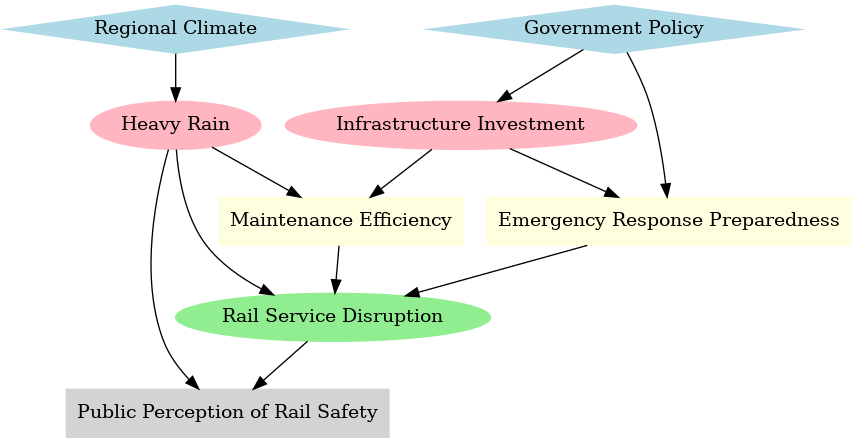

In [732]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [733]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

The recent reopening of the JR Kyudai Line, previously halted by heavy rain damage, presents an interesting opportunity to explore the relationship between extreme weather events and public transportation systems. By examining data on the frequency and severity of such weather events, along with the operational records of the railway, we could gain insights into how weather impacts rail travel, specifically looking at delays, cancellations, and restoration efforts.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using te

In [734]:
#################################################

structure_raw = '''
[
	{"sentence": "The climate of the region surprisingly influences the incidence of heavy rain, suggesting that broader environmental factors play a significant role in more localized weather events.", "involved": ["Regional Climate", "Heavy Rain"]},
	{"sentence": "Government policies, which shape the level of investment in rail infrastructure, have a notable impact on the quality and resilience of the rail network.", "involved": ["Government Policy", "Infrastructure Investment"]},
	{"sentence": "Interestingly, both the amount of rain and the investment in infrastructure together determine how well maintenance operations can cope with weather-related challenges.", "involved": ["Heavy Rain", "Infrastructure Investment", "Maintenance Efficiency"]},
	{"sentence": "The readiness of emergency response systems for rail incidents is affected not only by the level of infrastructure investment but also by government policies, highlighting the complex interplay between policy and practical preparedness.", "involved": ["Infrastructure Investment", "Government Policy", "Emergency Response Preparedness"]},
	{"sentence": "Rail service disruptions hinge on several factors: the efficiency of maintenance operations, the preparedness of emergency response, and the incidence of heavy rain, reflecting a multifaceted approach to understanding rail service reliability.", "involved": ["Maintenance Efficiency", "Emergency Response Preparedness", "Heavy Rain", "Rail Service Disruption"]},
	{"sentence": "Public perception of rail safety is shaped both by the occurrence of heavy rain and the actual disruptions to rail service, indicating how external events and service quality combine to form public opinion.", "involved": ["Heavy Rain", "Rail Service Disruption", "Public Perception of Rail Safety"]}
]

'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [735]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

The recent reopening of the JR Kyudai Line, previously halted by heavy rain damage, presents an interesting opportunity to explore the relationship between extreme weather events and public transportation systems. By examining data on the frequency and severity of such weather events, along with the operational records of the railway, we could gain insights into how weather impacts rail travel, specifically looking at delays, cancellations, and restoration efforts.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Regional Climate" is "Wet Climate" (rather than "Dry Climate")?
2. when "Regional Climate" is "Dry Climate": what is the probability that "Heavy Rain" is "Heavy Rain" (rather than "No Heavy Rain")?
3. when "Regional Climate" is "Wet Climate": what is the probabi

In [736]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.4, 0.6],
  "2": [0.1, 0.2],
  "3": [0.6, 0.8],
  "4": [0.5, 0.7],
  "5": [0.2, 0.4],
  "6": [0.6, 0.8],
  "7": [0.4, 0.6],
  "8": [0.2, 0.4],
  "9": [0.7, 0.9],
  "10": [0.5, 0.7],
  "11": [0.2, 0.3],
  "12": [0.4, 0.6],
  "13": [0.5, 0.7],
  "14": [0.7, 0.9],
  "15": [0.6, 0.8],
  "16": [0.3, 0.5],
  "17": [0.8, 0.9],
  "18": [0.5, 0.7],
  "19": [0.4, 0.6],
  "20": [0.1, 0.3],
  "21": [0.7, 0.8],
  "22": [0.3, 0.5],
  "23": [0.7, 0.9],
  "24": [0.3, 0.5],
  "25": [0.4, 0.6],
  "26": [0.6, 0.8]
}

'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [737]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions).item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

-------------------------  --------------  ----------------------  ----------------------------------------------------------
Heavy Rain                 No Heavy Rain   Heavy Rain              Incidence of heavy rain in the region
Infrastructure Investment  Low Investment  High Investment         Level of investment in rail infrastructure
Rail Service Disruption    No Disruption   Significant Disruption  Whether the rail service is significantly disrupted or not
-------------------------  --------------  ----------------------  ----------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Regional Climate' means Climatic conditions of the region
'Heavy Rain' means Incidence of heavy rain in the region
'Government Policy' means Government policies affecting public transportation
'Infrastructure Investment' means Level of investment in rail infrastructure
'Maintenance Efficiency' means Efficiency of rail maintenance operations
'Emergency Response Preparedness' means Readiness of emergency response systems for rail incidents
'Rail Service Disruption' means Whether the rail service is significantly disrupted or not
'Public Perception of Rail Safety' means Public perception regarding the safety of the rail network
Treatment Value    Treatment                  Outcome Value           Outcome                        ATE    Correlation
-----------------  -------------------------  ----------------------  -----------------------  ---------  -------------
Heavy Rain         Heavy Rain                 Significant Disruption  Rail Service Disruption   0.257849       0.246204
High I

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                             ATE    Correlation  Outcome
--------------------------------------------------  -----  -------------  --------------------------------------------------
Wet Climate Regional Climate                         0.61           0.61  Heavy Rain Heavy Rain
Wet Climate Regional Climate                         0              0     Favorable Policies Government Policy
Wet Climate Regional Climate                         0              0     High Investment Infrastructure Investment
Wet Climate Regional Climate                        -0.15          -0.16  Efficient Maintenance Efficiency
Wet Climate Regional Climate                         0              0     Prepared Emergency Response Preparedness
Wet Climate Regional Climate                         0.16           0.16  Significant Disruption Rail Service Disruption
Wet Climate Regional Climate                        -0.07          -0.07  Perceived as Safe Public Perception of Rail Safety
He

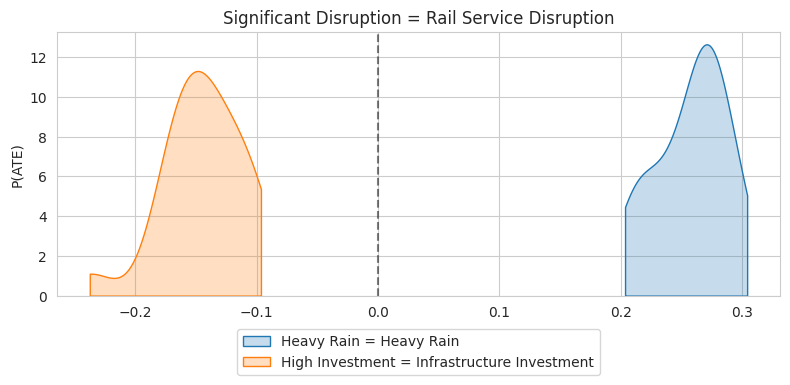

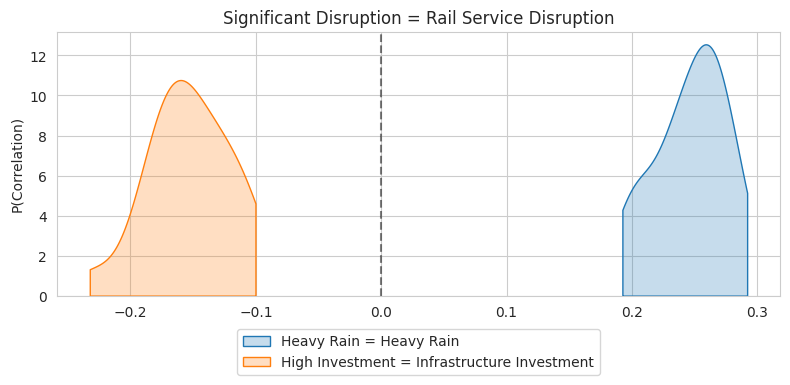

In [738]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [739]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Regional Climate' (0='Dry Climate', 1='Wet Climate') means Climatic conditions of the region
Variable 'Heavy Rain' (0='No Heavy Rain', 1='Heavy Rain') means Incidence of heavy rain in the region
Variable 'Government Policy' (0='Unfavo

In [742]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''
{
  "Regional Climate": {
    "descriptor": ["the regional climate", "the area's climatic conditions"],
    "subject": "this region",
    "predicate0": ["experiences drier weather", "is known for its dry climate"],
    "predicate1": ["experiences wetter weather", "is characterized by a wet climate"],
    "pronoun": "it",
    "nounclause0": ["the region experiences dry weather", "the area is known for its dry climate"],
    "nounclause1": ["the region experiences wet weather", "the area is characterized by a wet climate"],
    "preposition": ["in", "across"],
    "domain": "the region",
    "subclause0": ["dry weather is prevalent", "a dry climate dominates"],
    "subclause1": ["wet weather is prevalent", "a wet climate dominates"],
    "condition0": ["in a dry climate", "when the region has a dry weather pattern"],
    "condition1": ["in a wet climate", "when the region has a wet weather pattern"],
    "action0": ["the climate becomes drier", "the region experiences less rainfall"],
    "action1": ["the climate becomes wetter", "the region experiences more rainfall"]
  },
  "Heavy Rain": {
    "descriptor": ["the incidence of heavy rain", "heavy rainfall events"],
    "subject": "the region",
    "predicate0": ["does not experience heavy rain", "is free from heavy rainfall"],
    "predicate1": ["experiences heavy rain", "is hit by heavy rainfall"],
    "pronoun": "it",
    "nounclause0": ["there is no heavy rain in the region", "heavy rainfall is absent in the area"],
    "nounclause1": ["there is heavy rain in the region", "heavy rainfall occurs in the area"],
    "preposition": ["during", "in the case of"],
    "domain": "weather conditions",
    "subclause0": ["heavy rain is not present", "the weather is clear of heavy rainfall"],
    "subclause1": ["heavy rain occurs", "the weather includes heavy rainfall"],
    "condition0": ["without heavy rainfall", "when the region is not experiencing heavy rain"],
    "condition1": ["with heavy rainfall", "when the region is experiencing heavy rain"],
    "action0": ["heavy rain is prevented", "rainfall intensity is reduced"],
    "action1": ["heavy rain occurs", "rainfall intensity increases"]
  },
  "Government Policy": {
    "descriptor": ["the government's transportation policy", "public transportation policies"],
    "subject": "the government",
    "predicate0": ["adopts unfavorable policies for public transportation", "is not supportive of public transport"],
    "predicate1": ["adopts favorable policies for public transportation", "supports public transport"],
    "pronoun": "it",
    "nounclause0": ["government policies are unfavorable to public transportation", "public transport lacks government support"],
    "nounclause1": ["government policies are favorable to public transportation", "public transport receives strong government support"],
    "preposition": ["under", "with"],
    "domain": "governmental decisions",
    "subclause0": ["public transportation policies are not supportive", "there is a lack of support for public transport"],
    "subclause1": ["public transportation policies are supportive", "there is strong support for public transport"],
    "condition0": ["if public transport policies are unfavorable", "when the government does not support public transport"],
    "condition1": ["if public transport policies are favorable", "when the government supports public transport"],
    "action0": ["government policies shift against public transportation", "public transport support is withdrawn"],
    "action1": ["government policies favor public transportation", "support for public transport is increased"]
  },
  "Infrastructure Investment": {
    "descriptor": ["the level of infrastructure investment", "investment in rail infrastructure"],
    "subject": "the government",
    "predicate0": ["allocates low investment to rail infrastructure", "does not invest heavily in rail infrastructure"],
    "predicate1": ["allocates high investment to rail infrastructure", "invests heavily in rail infrastructure"],
    "pronoun": "it",
    "nounclause0": ["there is low investment in rail infrastructure", "rail infrastructure receives minimal investment"],
    "nounclause1": ["there is high investment in rail infrastructure", "rail infrastructure receives significant investment"],
    "preposition": ["with", "in the context of"],
    "domain": "transportation projects",
    "subclause0": ["investment in rail infrastructure is minimal", "rail infrastructure funding is low"],
    "subclause1": ["investment in rail infrastructure is substantial", "rail infrastructure funding is high"],
    "condition0": ["when investment in rail infrastructure is low", "if rail infrastructure funding is minimal"],
    "condition1": ["when investment in rail infrastructure is high", "if rail infrastructure funding is substantial"],
    "action0": ["rail infrastructure investment is reduced", "funding for rail projects is cut"],
    "action1": ["rail infrastructure investment is increased", "funding for rail projects is boosted"]
  },
  "Maintenance Efficiency": {
    "descriptor": ["the efficiency of rail maintenance", "maintenance operations efficiency"],
    "subject": "rail maintenance",
    "predicate0": ["is inefficient", "fails to meet standards"],
    "predicate1": ["is efficient", "meets high standards"],
    "pronoun": "it",
    "nounclause0": ["rail maintenance is not carried out efficiently", "maintenance operations fall short of efficiency"],
    "nounclause1": ["rail maintenance is carried out efficiently", "maintenance operations meet high standards"],
    "preposition": ["in", "during"],
    "domain": "railway upkeep",
    "subclause0": ["maintenance operations are not efficient", "there is a lack of efficiency in maintenance"],
    "subclause1": ["maintenance operations are efficient", "there is high efficiency in maintenance"],
    "condition0": ["if rail maintenance is inefficient", "when maintenance operations do not meet standards"],
    "condition1": ["if rail maintenance is efficient", "when maintenance operations meet high standards"],
    "action0": ["maintenance efficiency declines", "rail upkeep becomes less efficient"],
    "action1": ["maintenance efficiency improves", "rail upkeep becomes more efficient"]
  },
  "Emergency Response Preparedness": {
    "descriptor": ["the emergency response readiness", "preparedness for rail incidents"],
    "subject": "emergency response systems",
    "predicate0": ["are unprepared for rail incidents", "lack readiness for emergencies"],
    "predicate1": ["are prepared for rail incidents", "are ready for emergencies"],
    "pronoun": "they",
    "nounclause0": ["there is a lack of preparedness for rail emergencies", "emergency systems are unprepared"],
    "nounclause1": ["there is strong preparedness for rail emergencies", "emergency systems are ready"],
    "preposition": ["in terms of", "with regards to"],
    "domain": "emergency situations",
    "subclause0": ["preparedness for emergencies is lacking", "emergency systems are not ready"],
    "subclause1": ["preparedness for emergencies is strong", "emergency systems are well-prepared"],
    "condition0": ["if emergency systems are unprepared", "when there is a lack of emergency preparedness"],
    "condition1": ["if emergency systems are prepared", "when there is strong emergency preparedness"],
    "action0": ["emergency preparedness is not prioritized", "readiness for rail incidents is neglected"],
    "action1": ["emergency preparedness is enhanced", "readiness for rail incidents is ensured"]
  },
  "Rail Service Disruption": {
    "descriptor": ["the stability of train services", "the regularity of rail operations"],
    "subject": "trains",
    "predicate0": ["run on schedule", "operate without interruptions"],
    "predicate1": ["face significant delays", "experience major disruptions"],
    "pronoun": "they",
    "nounclause0": ["trains are running on time", "there are no disruptions in rail services"],
    "nounclause1": ["trains are significantly delayed", "major disruptions are affecting rail services"],
    "preposition": ["in", "among"],
    "domain": "situations",
    "subclause0": ["trains run smoothly", "rail services operate as expected"],
    "subclause1": ["train schedules are heavily disrupted", "rail services are significantly affected"],
    "condition0": ["If trains are running on time", "When there are no disruptions"],
    "condition1": ["If train services face major disruptions", "When significant delays occur"],
    "action0": ["schedules are strictly adhered to", "effective management prevents disruptions"],
    "action1": ["unexpected events disrupt the schedule", "severe conditions lead to service disruptions"]
  },
  "Public Perception of Rail Safety": {
    "descriptor": ["public confidence in rail safety", "the public's view on train safety"],
    "subject": "passengers",
    "predicate0": ["are concerned about rail safety", "doubt the safety of trains"],
    "predicate1": ["feel secure while traveling by train", "trust the safety of the rail network"],
    "pronoun": "they",
    "nounclause0": ["people are worried about rail safety", "there are concerns regarding train safety"],
    "nounclause1": ["people feel safe when using trains", "public trust in rail safety is high"],
    "preposition": ["among", "within"],
    "domain": "groups",
    "subclause0": ["safety concerns are raised by passengers", "doubts about rail safety prevail"],
    "subclause1": ["a sense of security is felt by passengers", "confidence in train safety is expressed"],
    "condition0": ["When safety concerns are high", "If there are doubts about rail safety"],
    "condition1": ["When passengers feel safe", "If the public trusts the rail network"],
    "action0": ["measures are not taken to ensure safety", "lapses in safety protocols occur"],
    "action1": ["strict safety standards are maintained", "efforts to ensure safety are recognized"]
  }
}

'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)
assert all(node['name'] in ctx['verbs'] for node in nodes)

In [743]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

The recent reopening of the JR Kyudai Line, previously halted by heavy rain damage, presents an interesting opportunity to explore the relationship between extreme weather events and public transportation systems. By examining data on the frequency and severity of such weather events, along with the operational records of the railway, we could gain insights into how weather impacts rail travel, specifically looking at delays, cancellations, and restoration efforts.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Heavy Rain') > 0
	2. ATE('Infrastructure Investment') < 0
	3. ATE('Heavy Rain') < ATE('Infrastructure Investment')
	4. |ATE('Heavy Rain')| < |ATE('Infrastructure Investment')|
	5. CATE('Heavy Rain' | 'Regional Climate' = 0) > 0
	6. CATE('Inf

In [744]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {"question": "Does heavy rain generally lead to more rail service disruptions?", "answer": "yes", "claim": "Heavy rain generally leads to more rail service disruptions."},
    "2": {"question": "Does higher investment in rail infrastructure generally lead to fewer rail service disruptions?", "answer": "yes", "claim": "Higher investment in rail infrastructure generally leads to fewer rail service disruptions."},
    "3": {"question": "Is the impact of heavy rain on rail service disruptions greater than that of infrastructure investment?", "answer": "no", "claim": "The impact of infrastructure investment on rail service disruptions is greater than that of heavy rain."},
    "4": {"question": "Is the absolute impact of heavy rain on rail service disruptions less than that of infrastructure investment?", "answer": "yes", "claim": "The absolute impact of infrastructure investment on rail service disruptions is greater than that of heavy rain."},
    "5": {"question": "In regions with a dry climate, does heavy rain lead to more rail service disruptions?", "answer": "yes", "claim": "In regions with a dry climate, heavy rain leads to more rail service disruptions."},
    "6": {"question": "In regions with a dry climate, does higher investment in rail infrastructure lead to fewer rail service disruptions?", "answer": "yes", "claim": "In regions with a dry climate, higher investment in rail infrastructure leads to fewer rail service disruptions."},
    "7": {"question": "In regions with a dry climate, is the impact of infrastructure investment on rail service disruptions less than that of heavy rain?", "answer": "no", "claim": "In regions with a dry climate, the impact of infrastructure investment on rail service disruptions is greater than that of heavy rain."},
    "8": {"question": "In regions with a dry climate, is the absolute impact of infrastructure investment on rail service disruptions less than that of heavy rain?", "answer": "yes", "claim": "In regions with a dry climate, the absolute impact of heavy rain on rail service disruptions is greater than that of infrastructure investment."},
    "9": {"question": "In regions with a wet climate, does heavy rain lead to fewer rail service disruptions?", "answer": "yes", "claim": "In regions with a wet climate, heavy rain leads to fewer rail service disruptions."},
    "10": {"question": "In regions with a wet climate, does higher investment in rail infrastructure lead to fewer rail service disruptions?", "answer": "yes", "claim": "In regions with a wet climate, higher investment in rail infrastructure leads to fewer rail service disruptions."},
    "11": {"question": "In regions with a wet climate, is the impact of heavy rain on rail service disruptions greater than that of infrastructure investment?", "answer": "no", "claim": "In regions with a wet climate, the impact of infrastructure investment on rail service disruptions is greater than that of heavy rain."},
    "12": {"question": "In regions with a wet climate, is the absolute impact of infrastructure investment on rail service disruptions greater than that of heavy rain?", "answer": "yes", "claim": "In regions with a wet climate, the absolute impact of infrastructure investment on rail service disruptions is greater than that of heavy rain."},
    "13": {"question": "Is the impact of heavy rain on rail service disruptions greater in regions with a wet climate compared to dry regions?", "answer": "yes", "claim": "The impact of heavy rain on rail service disruptions is greater in regions with a wet climate compared to dry regions."},
    "14": {"question": "Is the absolute impact of heavy rain on rail service disruptions greater in regions with a dry climate compared to wet regions?", "answer": "yes", "claim": "The absolute impact of heavy rain on rail service disruptions is greater in regions with a dry climate compared to wet regions."},
    "15": {"question": "Is the impact of infrastructure investment on rail service disruptions greater in regions with a dry climate compared to wet regions?", "answer": "yes", "claim": "The impact of infrastructure investment on rail service disruptions is greater in regions with a dry climate compared to wet regions."},
    "16": {"question": "Is the absolute impact of infrastructure investment on rail service disruptions less in regions with a dry climate compared to wet regions?", "answer": "yes", "claim": "The absolute impact of infrastructure investment on rail service disruptions is less in regions with a dry climate compared to wet regions."},
    "17": {"question": "Under unfavorable government policies, does heavy rain lead to more rail service disruptions?", "answer": "yes", "claim": "Under unfavorable government policies, heavy rain leads to more rail service disruptions."},
    "18": {"question": "Under unfavorable government policies, does higher investment in rail infrastructure lead to fewer rail service disruptions?", "answer": "yes", "claim": "Under unfavorable government policies, higher investment in rail infrastructure leads to fewer rail service disruptions."},
    "19": {"question": "Under unfavorable government policies, is the impact of heavy rain on rail service disruptions greater than that of infrastructure investment?", "answer": "no", "claim": "Under unfavorable government policies, the impact of infrastructure investment on rail service disruptions is greater than that of heavy rain."},
    "20": {"question": "Under unfavorable government policies, is the absolute impact of heavy rain on rail service disruptions greater than that of infrastructure investment?", "answer": "yes", "claim": "Under unfavorable government policies, the absolute impact of heavy rain on rail service disruptions is greater than that of infrastructure investment."},
    "21": {"question": "Under favorable government policies, does heavy rain lead to more rail service disruptions?", "answer": "yes", "claim": "Under favorable government policies, heavy rain leads to more rail service disruptions."},
    "22": {"question": "Under favorable government policies, does higher investment in rail infrastructure lead to fewer rail service disruptions?", "answer": "yes", "claim": "Under favorable government policies, higher investment in rail infrastructure leads to fewer rail service disruptions."},
    "23": {"question": "Under favorable government policies, is the impact of heavy rain on rail service disruptions greater than that of infrastructure investment?", "answer": "no", "claim": "Under favorable government policies, the impact of infrastructure investment on rail service disruptions is greater than that of heavy rain."},
    "24": {"question": "Under favorable government policies, is the absolute impact of infrastructure investment on rail service disruptions greater than that of heavy rain?", "answer": "yes", "claim": "Under favorable government policies, the absolute impact of infrastructure investment on rail service disruptions is greater than that of heavy rain."},
    "25": {"question": "Is the impact of heavy rain on rail service disruptions greater under favorable government policies compared to unfavorable ones?", "answer": "yes", "claim": "The impact of heavy rain on rail service disruptions is greater under favorable government policies compared to unfavorable ones."},
    "26": {"question": "Is the absolute impact of heavy rain on rail service disruptions greater under favorable government policies compared to unfavorable ones?", "answer": "yes", "claim": "The absolute impact of heavy rain on rail service disruptions is greater under favorable government policies compared to unfavorable ones."},
    "27": {"question": "Is the impact of infrastructure investment on rail service disruptions greater under favorable government policies compared to unfavorable ones?", "answer": "yes", "claim": "The impact of infrastructure investment on rail service disruptions is greater under favorable government policies compared to unfavorable ones."},
    "28": {"question": "Is the absolute impact of infrastructure investment on rail service disruptions less under favorable government policies compared to unfavorable ones?", "answer": "yes", "claim": "The absolute impact of infrastructure investment on rail service disruptions is less under favorable government policies compared to unfavorable ones."}
}

'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [745]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Impact_of_Extreme_Weather_on_JR_Kyudai_Line_Operations.json'